In [156]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os 

# 设置保存图片的途径
PROJECT_ROOT_DIR = "."
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGE_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True):
    '''
    运行即可保存自动图片
    
    :param fig_id: 图片名称
    '''
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [157]:
# 读取数据集
df = pd.read_excel('dataset.xlsx', engine='openpyxl')
df.head()

,TRUE VALUE,SiO2 (wt. %),TiO2 (wt. %),Al2O3 (wt. %),Cr2O3 (wt. %),FeO (wt. %),MnO (wt. %),MgO (wt. %),CaO (wt. %),Na2O (wt. %),IV (Al),H2O (wt. %)
0,1,47.604,2.858,5.749,0.062,7.024,0.087,12.625,22.916,0.328,0.207900,0.061750
1,1,51.788,1.166,2.557,0.475,6.801,0.145,14.762,21.743,0.327,0.080071,0.014881
2,1,46.561,3.109,6.139,0.145,6.914,0.037,12.478,23.112,0.620,0.238984,0.023204
3,1,46.344,3.170,7.776,0.014,6.842,0.068,11.688,23.067,0.574,0.258931,0.049703
4,1,50.180,1.965,3.294,0.106,5.729,0.063,13.603,23.626,0.540,0.121500,0.019333


In [158]:
# 查看数据集是否有空值，看需不需要插值
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TRUE VALUE     2272 non-null   int64  
 1   SiO2 (wt. %)   2272 non-null   float64
 2   TiO2 (wt. %)   2272 non-null   float64
 3   Al2O3 (wt. %)  2272 non-null   float64
 4   Cr2O3 (wt. %)  2272 non-null   float64
 5   FeO (wt. %)    2272 non-null   float64
 6   MnO (wt. %)    2272 non-null   float64
 7   MgO (wt. %)    2272 non-null   float64
 8   CaO (wt. %)    2272 non-null   float64
 9   Na2O  (wt. %)  2272 non-null   float64
 10  IV (Al)        2272 non-null   float64
 11  H2O (wt. %)    2272 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 213.1 KB


In [159]:
# 将真实的分类标签与特征分开
data = df.drop('TRUE VALUE', axis=1)
labels = df['TRUE VALUE'].copy()
np.unique(labels)

array([-1,  0,  1])

In [160]:
labels

0       1
1       1
2       1
3       1
4       1
       ..
2267    0
2268    0
2269    0
2270    0
2271    0
Name: TRUE VALUE, Length: 2272, dtype: int64

In [161]:
# 获取数据的数量和特征的数量
n_samples, n_features = data.shape
# 获取分类标签的数量
n_labels = len(np.unique(labels))

In [162]:
np.unique(labels)

array([-1,  0,  1])

In [163]:
labels.value_counts()

 1    1488
-1     467
 0     317
Name: TRUE VALUE, dtype: int64

# KMeans聚类，探索数据内部特征，进行分类

In [164]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

def plot_scores(init, max_k, data, labels):
    '''画出kmeans不同初始化方法的三种评分图
    
    :param init: 初始化方法,有'k-means++'和'random'两种
    :param max_k: 最大的簇中心数目
    :param data: 特征的数据集
    :param labels: 真实标签的数据集
    '''
    
    i = []
    inertia_scores = []
    y_silhouette_scores = []
    y_calinski_harabaz_scores = []
    
    for k in range(2, max_k):
        kmeans_model = KMeans(n_clusters=k, random_state=1, init=init, n_init=10)
        pred = kmeans_model.fit_predict(data)
        i.append(k)
        inertia_scores.append(kmeans_model.inertia_)
        y_silhouette_scores.append(silhouette_score(data, pred))
        y_calinski_harabaz_scores.append(calinski_harabasz_score(data, pred))
    
    new = [inertia_scores, y_silhouette_scores, y_calinski_harabaz_scores]
    for j in range(len(new)):
        plt.figure(j+1)
        plt.plot(i, new[j], 'bo-')
        plt.xlabel('n_clusters')
        if j == 0:
            name = 'inertia'
        elif j == 1:
            name = 'silhouette'
        else:
            name = 'calinski_harabasz'
        plt.ylabel('{}_scores'.format(name))
        plt.title('{}_scores with {} init'.format(name, init))
        save_fig('{} with {}'.format(name, init))

Saving figure inertia with k-means++
Saving figure silhouette with k-means++
Saving figure calinski_harabasz with k-means++


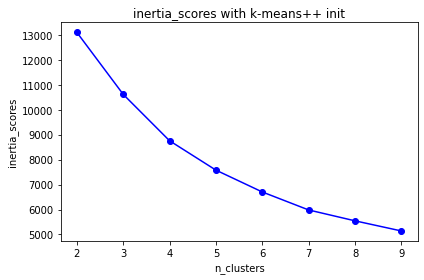

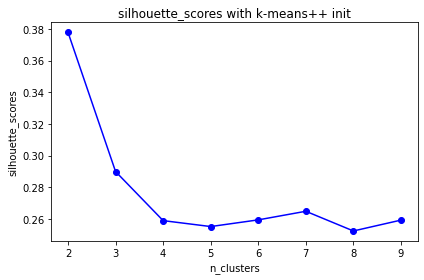

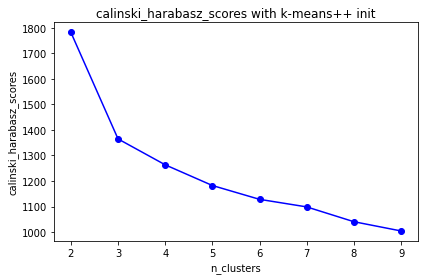

In [165]:
# 使用k-means进行聚类，设置簇=2，设置初始化方式为'k-means++'
plot_scores('k-means++', 10, data, labels)

In [166]:
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl

def plot_silhouette_diagram(clusterer, X, show_xlabels=True,
                            show_ylabels=True, show_title=True):
    """
    画轮廓图表
    
    :param clusterer: 训练好的聚类模型（这里是能提前设置簇数量的，可以稍微修改代码换成不能提前设置的）
    :param X: 只含特征的数据集
    :param show_xlabels: 为真，添加横坐标信息
    :param show_ylabels: 为真，添加纵坐标信息
    :param show_title: 为真，添加图表名
    """
    
    y_pred = clusterer.labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)
    silhouette_average = silhouette_score(X, y_pred)
    
    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(clusterer.n_clusters):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        
        color = mpl.cm.Spectral(i / clusterer.n_clusters)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding
    
    plt.axvline(x=silhouette_average, color="red", linestyle="--")
    
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(clusterer.n_clusters)))
    
    if show_xlabels:
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("Cluster")
    if show_title:
        plt.title("init:{}  n_cluster:{}".format(clusterer.init, clusterer.n_clusters))

In [167]:
from sklearn.cluster import KMeans

# 使用k-means进行聚类，设置初始化方式为'k-means++'，根据上述结果设置簇分别为2和3
km1 = KMeans(init='k-means++', n_clusters=2, n_init=10, random_state=42)
km2 = KMeans(init='k-means++', n_clusters=3, n_init=10, random_state=42)
km1.fit(data)
km2.fit(data)
print("n_labels: %d \t n_samples: %d \t n_features: %d" % (n_labels, n_samples, n_features))

n_labels: 3 	 n_samples: 2272 	 n_features: 11


Saving figure silhouette_diagram


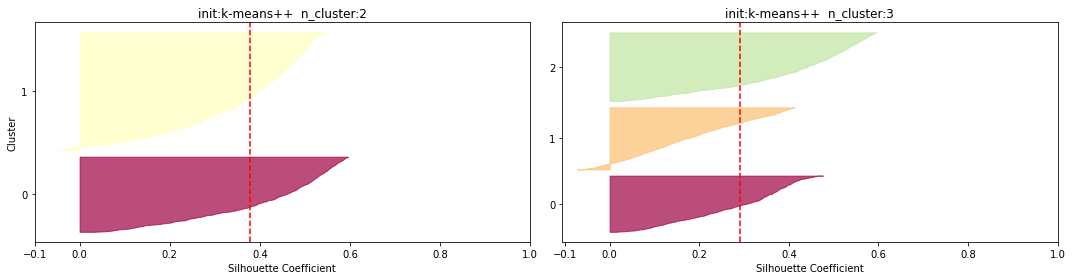

In [168]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plot_silhouette_diagram(km1, data)
plt.subplot(122)
plot_silhouette_diagram(km2, data, show_ylabels=False)
save_fig("silhouette_diagram")

# pca降维后聚类，数据可视化

In [169]:
from sklearn.preprocessing import StandardScaler

# 降维前先需要对数据进行标准化处理
scaler = StandardScaler()
data_processed = pd.DataFrame(scaler.fit_transform(data))

In [170]:
from sklearn.decomposition import PCA

# 使用普通PCA降维，将特征降至2维，作二维平面可视化，PCA假定以原点为中心，会自动将数据集中心化处理
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_processed)
# 使用k-means进行聚类，设置簇=3，初始化方法为'k-means++'和‘random’
kmeans1 = KMeans(init="k-means++", n_clusters=3, n_init=3)
kmeans2 = KMeans(init="random", n_clusters=3, n_init=3)
kmeans1.fit(reduced_data)
kmeans2.fit(reduced_data)

KMeans(init='random', n_clusters=3, n_init=3)

In [171]:
# 主成分轴在特征空间的权重系数
pca.components_

array([[-0.42113472,  0.41548467,  0.36557801, -0.15419825,  0.06432417,
        -0.12771227, -0.40822211,  0.24756898,  0.24712526,  0.41062427,
         0.12052699],
       [-0.03741971, -0.00905855,  0.04400909, -0.30989707,  0.64611524,
         0.52494983, -0.11020771, -0.3804949 ,  0.11273722, -0.01373595,
        -0.19413145]])

In [172]:
# 沿着每个主成分轴的信息保留率
pca.explained_variance_ratio_

array([0.45075653, 0.18692661])

In [173]:
# 2维的特征值（降维后）
reduced_data

array([[ 3.9380202 , -0.4596334 ],
       [-1.49280185,  0.05266333],
       [ 5.06457565, -0.44515568],
       ...,
       [-2.88009113,  1.95107869],
       [-3.12958423,  1.61244563],
       [-3.75394313,  2.89601684]])

In [174]:
# 3个簇中心的坐标，初始化方法为'k-means++'
kmeans1.cluster_centers_

array([[-1.52400094,  1.18683109],
       [-1.27149697, -1.44906482],
       [ 2.36979341, -0.01605858]])

In [175]:
# 3个簇中心的坐标，初始化方法为'random'
kmeans2.cluster_centers_

array([[-1.51480254,  1.18597686],
       [ 2.35271803, -0.02272335],
       [-1.30581727, -1.46137888]])

In [176]:
from matplotlib.colors import ListedColormap

def plot_data(X, real_tag=None):
    """
    画散点图
    
    :param X: 只含特征值的数据集 
    :param real_tag: 有值，则给含有不同分类的散点上色
    """
    try:
        if not real_tag:
            plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    except ValueError:
        types = list(np.unique(real_tag))
        for i in range(len(types)):
            plt.plot(X[:, 0][real_tag==types[i]], X[:, 1][real_tag==types[i]],
                     '.', label="{}".format(types[i]), markersize=3)
            plt.legend()

def plot_centroids(centroids, circle_color='w', cross_color='k'):
    """
    画出簇中心
    
    :param centroids: 簇中心坐标
    :param circle_color: 圆圈的颜色
    :param cross_color: 叉的颜色
    """
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, zorder=10, linewidths=8,
                color=circle_color, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, zorder=11, linewidths=3,
                color=cross_color, alpha=1)

def plot_centroids_labels(clusterer):
    labels = np.unique(clusterer.labels_)
    centroids = clusterer.cluster_centers_
    for i in range(centroids.shape[0]):
        t = str(labels[i])
        plt.text(centroids[i, 0]-1, centroids[i, 1]-1, t, fontsize=25,
                 zorder=10, bbox=dict(boxstyle='round', fc='yellow', alpha=0.5))
    
def plot_decision_boundaried(clusterer, X, tag=None, resolution=1000, 
                             show_centroids=True, show_xlabels=True,
                             show_ylabels=True, show_title=True,
                             show_centroids_labels=False):
    """
    画出决策边界，并填色
    
    :param clusterer: 训练好的聚类模型（能提前设置簇中心数量或不能提前设置都可以）
    :param X: 只含特征值的数据集
    :param tag: 只含真实分类信息的数据集，有值，则给散点上色
    :param resolution: 类似图片分辨率，给最小的单位上色
    :param show_centroids: 为真，画出簇中心
    :param show_centroids_labels: 为真，标注出该簇中心的标签
    """
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # 可用color code或者color自定义填充颜色
    # custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])
    plt.contourf(xx, yy, Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                 cmap="Pastel2")
    plt.contour(xx, yy, Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                 colors='k')
    
    try:
        if not tag:
            plot_data(X)
    except ValueError:
        plot_data(X, real_tag=tag)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)
    if show_centroids_labels:
        plot_centroids_labels(clusterer)
    if show_xlabels:
        plt.xlabel(r"$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel(r"$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    if show_title:
        plt.title("init:{}  n_cluster:{}".format(clusterer.init, clusterer.n_clusters))

Saving figure real_tag_vs_non


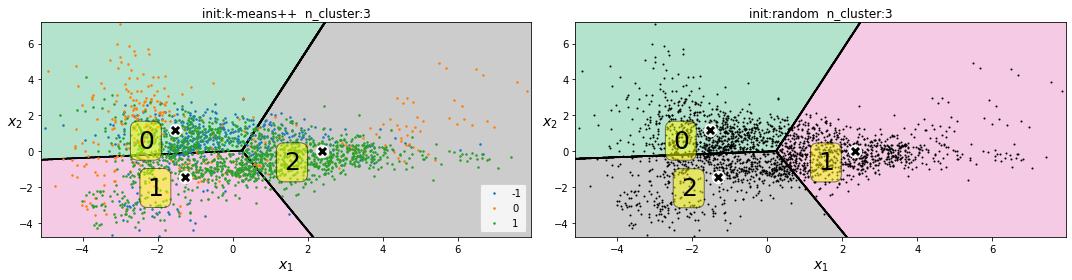

In [177]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plot_decision_boundaried(kmeans1, reduced_data, tag=labels, show_centroids_labels=True)
plt.subplot(122)
plot_decision_boundaried(kmeans2, reduced_data, show_centroids_labels=True)
save_fig("real_tag_vs_non")
plt.show()

In [178]:
kmeans3 = KMeans(init="k-means++", n_clusters=3, n_init=3)
kmeans4 = KMeans(init="k-means++", n_clusters=4, n_init=3)
kmeans5 = KMeans(init="k-means++", n_clusters=5, n_init=3)
kmeans6 = KMeans(init="k-means++", n_clusters=6, n_init=3)

kmeans3.fit(reduced_data)
kmeans4.fit(reduced_data)
kmeans5.fit(reduced_data)
kmeans6.fit(reduced_data)

KMeans(n_clusters=6, n_init=3)

Saving figure reduced_and_cluster


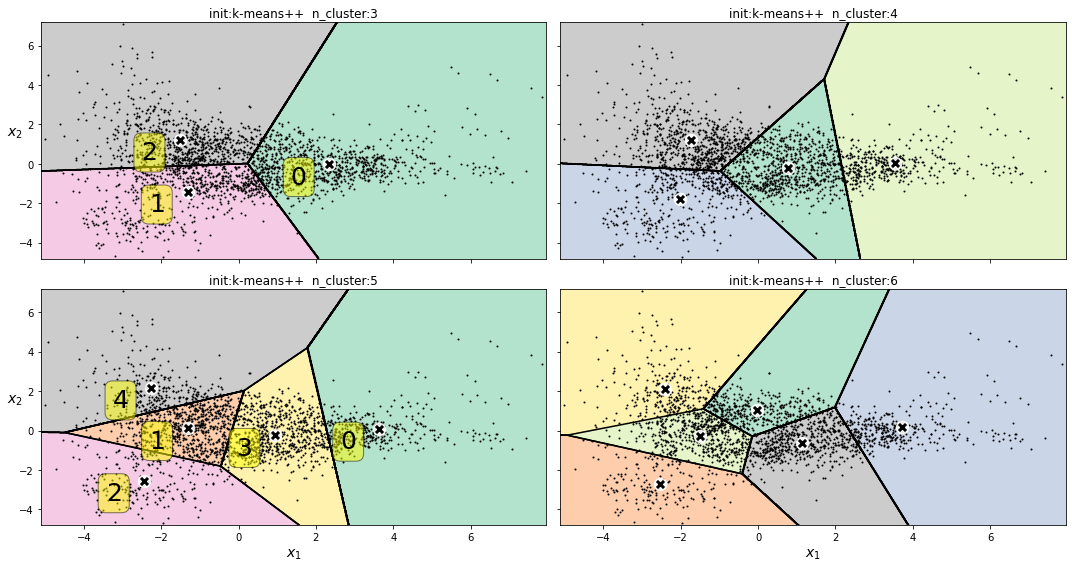

In [179]:
plt.figure(figsize=(15, 8))
plt.subplot(221)
plot_decision_boundaried(kmeans3, reduced_data, show_xlabels=False, show_centroids_labels=True)
plt.subplot(222)
plot_decision_boundaried(kmeans4, reduced_data, show_ylabels=False, show_xlabels=False)
plt.subplot(223)
plot_decision_boundaried(kmeans5, reduced_data, show_centroids_labels=True)
plt.subplot(224)
plot_decision_boundaried(kmeans6, reduced_data, show_ylabels=False)
save_fig("reduced_and_cluster")
plt.show()

# 基于聚类结果的分层抽样与随机抽样的比较

In [180]:
# 由于降维后丢失信息过多，所以将未降维的聚类结果写入原始表格中
df['km_clustering_label'] = km2.labels_

In [181]:
# 聚类的标签类别
df['km_clustering_label'].unique()

array([2, 1, 0], dtype=int32)

In [182]:
# data2是去掉真实分类信息的数据集（含有聚类后的结果）
data2 = df.drop("TRUE VALUE", axis=1)
data2.head()

,SiO2 (wt. %),TiO2 (wt. %),Al2O3 (wt. %),Cr2O3 (wt. %),FeO (wt. %),MnO (wt. %),MgO (wt. %),CaO (wt. %),Na2O (wt. %),IV (Al),H2O (wt. %),km_clustering_label
0,47.604,2.858,5.749,0.062,7.024,0.087,12.625,22.916,0.328,0.207900,0.061750,2
1,51.788,1.166,2.557,0.475,6.801,0.145,14.762,21.743,0.327,0.080071,0.014881,1
2,46.561,3.109,6.139,0.145,6.914,0.037,12.478,23.112,0.620,0.238984,0.023204,2
3,46.344,3.170,7.776,0.014,6.842,0.068,11.688,23.067,0.574,0.258931,0.049703,2
4,50.180,1.965,3.294,0.106,5.729,0.063,13.603,23.626,0.540,0.121500,0.019333,1


<AxesSubplot:>

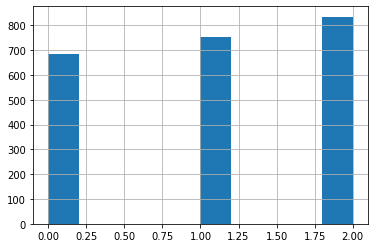

In [183]:
# 查看使用kmeans聚类后的分类标签值，三类
data2['km_clustering_label'].hist()

In [184]:
from sklearn.model_selection import StratifiedShuffleSplit

# 基于kmeans聚类结果的分层抽样
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data2, data2["km_clustering_label"]):
    strat_train_set = data2.loc[train_index]
    strat_test_set = data2.loc[test_index]

In [185]:
def clustering_result_propotions(data):
    """
    分层抽样后，训练集或测试集里不同分类标签的数量比
    :param data: 训练集或测试集，纯随机取样或分层取样
    """
    return data["km_clustering_label"].value_counts() / len(data)

In [186]:
# 经过分层抽样的测试集中，不同分类标签的数量比
clustering_result_propotions(strat_test_set)

2    0.367033
1    0.331868
0    0.301099
Name: km_clustering_label, dtype: float64

In [187]:
# 经过分层抽样的训练集中，不同分类标签的数量比
clustering_result_propotions(strat_train_set)

2    0.367639
1    0.331866
0    0.300495
Name: km_clustering_label, dtype: float64

In [188]:
# 完整的数据集中，不同分类标签的数量比
clustering_result_propotions(data2)

2    0.367518
1    0.331866
0    0.300616
Name: km_clustering_label, dtype: float64

In [189]:
from sklearn.model_selection import train_test_split

# 纯随机取样
random_train_set, random_test_set = train_test_split(data2, test_size=0.2, random_state=42)

# 完整的数据集、分层抽样后的测试集、纯随机抽样后的测试集中，不同分类标签的数量比
compare_props = pd.DataFrame({
    "Overall": clustering_result_propotions(data2),
    "Stratified": clustering_result_propotions(strat_test_set),
    "Random": clustering_result_propotions(random_test_set),
}).sort_index()

# 计算分层抽样和纯随机抽样后的测试集中不同分类标签的数量比，和完整的数据集中不同分类标签的数量比的误差
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Start. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

,Overall,Stratified,Random,Rand. %error,Start. %error
0,0.300616,0.301099,0.318681,6.009364,0.160571
1,0.331866,0.331868,0.314286,-5.297461,0.000583
2,0.367518,0.367033,0.367033,-0.131868,-0.131868


In [195]:
from sklearn.metrics import f1_score

def get_classification_marks(model, data, labels, train_index, test_index):
    """
    获取分类模型（二元或多元分类器）的评分：F1值
    :param data: 只含有特征值的数据集
    :param labels: 只含有标签值的数据集
    :param train_index: 分层抽样获取的训练集中数据的索引
    :param test_index: 分层抽样获取的测试集中数据的索引
    :return: F1评分值
    """
    m = model(random_state=42)
    m.fit(data.loc[train_index], labels.loc[train_index])
    test_labels_predict = m.predict(data.loc[test_index])
    score = f1_score(labels.loc[test_index], test_labels_predict, average="weighted")
    return score

In [196]:
from sklearn.linear_model import SGDClassifier

# 用分层抽样后的训练集训练分类模型后的评分值
start_marks = get_classification_marks(SGDClassifier, data, labels, strat_train_set.index, strat_test_set.index)
start_marks

0.6448791383164619

In [197]:
# 用纯随机抽样后的训练集训练分类模型后的评分值
random_marks = get_classification_marks(SGDClassifier, data, labels, random_train_set.index, random_test_set.index)
random_marks

0.6656144728729727

# 基于分层抽样的k折交叉验证，以xgboost为例

In [269]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone, BaseEstimator, TransformerMixin

class stratified_cross_val_score(BaseEstimator, TransformerMixin):
    """实现基于分层抽样的k折交叉验证"""
    
    def __init__(self, model, data, labels, random_state=0, cv=5):
        """
        :model: 训练的模型（回归或分类）
        :data: 只含特征值的完整数据集
        :labels: 只含标签值的完整数据集
        :random_state: 模型的随机种子值
        :cv: 交叉验证的次数
        """
        self.model = model
        self.data = data
        self.labels = labels
        self.random_state = random_state
        self.cv = cv
        self.score = []  # 储存每折测试集的模型评分
        self.preserve = [] # 储存每折训练的模型
        self.i = 0            
    
    def fit(self, X, y):
        """
        :param X: 含有特征值和聚类结果的完整数据集
        :param y: 含有聚类结果的完整数据集
        :return: 每一折交叉验证的评分
        """
        skfolds = StratifiedKFold(n_splits=self.cv, random_state=self.random_state)

        for train_index, test_index in skfolds.split(X, y):
            # 复制要训练的模型（分类或回归）
            clone_model = clone(self.model)
            strat_X_train_folds = self.data.loc[train_index]
            strat_y_train_folds = self.labels.loc[train_index]
            strat_X_test_fold = self.data.loc[test_index]
            strat_y_test_fold = self.labels.loc[test_index]
            
            # 训练模型
            clone_model.fit(strat_X_train_folds, strat_y_train_folds)
            
            # 预测值（这里是分类模型的分类结果）
            test_labels_pred = clone_model.predict(strat_X_test_fold)
            
            # 这里使用的是分类模型用的F1值，如果是回归模型可以换成相应的模型
            score_fold = f1_score(labels.loc[test_index], test_labels_pred, average="weighted")
            
            # 避免重复向列表里重复添加值
            if self.i < self.cv:
                self.score.append(score_fold)
                self.preserve.append(clone_model)
            else:
                None
                
            self.i += 1
    
    def transform(self, X, y=None):
        return self

    def best_estimator_(self):
        """返回交叉验证的最好评分模型"""
        index = np.argmax(np.array(self.score)) 
        return self.preserve[index]
    
    def mean(self):
        """返回交叉验证评分的平均值"""
        return np.array(self.score).mean()
    
    def std(self):
        """返回交叉验证评分的标准差"""
        return np.array(self.score).std()

In [270]:
# 可在docs或terminal使用pip3 install xgboost
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed")
    xgboost = None

In [271]:
# 分类模型
xgb_clf = xgboost.XGBClassifier(max_depth=4, learning_rate=0.1,
                                n_estimators=100, random_state=42)

# 基于分层抽样的交叉验证，data是只含特征值的完整数据集，labels是只含标签值的完整数据集
clf_cross_val = stratified_cross_val_score(xgb_clf, data, labels, cv=5, random_state=42)

In [272]:
# data2是含有特征值和聚类结果的完整数据集
clf_cross_val.fit(data2, data2["km_clustering_label"])

# 每折交叉验证的评分
clf_cross_val.score

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:43:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:43:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:43:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:43:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the object

[0.9129904257466386,
 0.8822890492015888,
 0.918780804939784,
 0.9288347897431366,
 0.6724829926608263]

In [273]:
# 交叉验证评分的平均值
clf_cross_val.mean()

0.8630756124583948

In [274]:
# 交叉验证评分的标准差
clf_cross_val.std()

0.09655416026763441

In [277]:
# 交叉验证的最好评分模型
best_clf = clf_cross_val.best_estimator_

In [278]:
# xgboost模型的特征重要性
for feature_name, score in zip(list(data.columns), best_clf().feature_importances_):
    print(feature_name, ":", score)

SiO2 (wt. %) : 0.04269698
TiO2 (wt. %) : 0.19630554
Al2O3 (wt. %) : 0.06312951
Cr2O3 (wt. %) : 0.05837539
FeO (wt. %) : 0.09346539
MnO (wt. %) : 0.061846323
MgO (wt. %) : 0.047740698
CaO (wt. %) : 0.058960427
Na2O  (wt. %) : 0.08320005
IV (Al) : 0.09709422
H2O (wt. %) : 0.19718547


Saving figure xgb_feature_importance


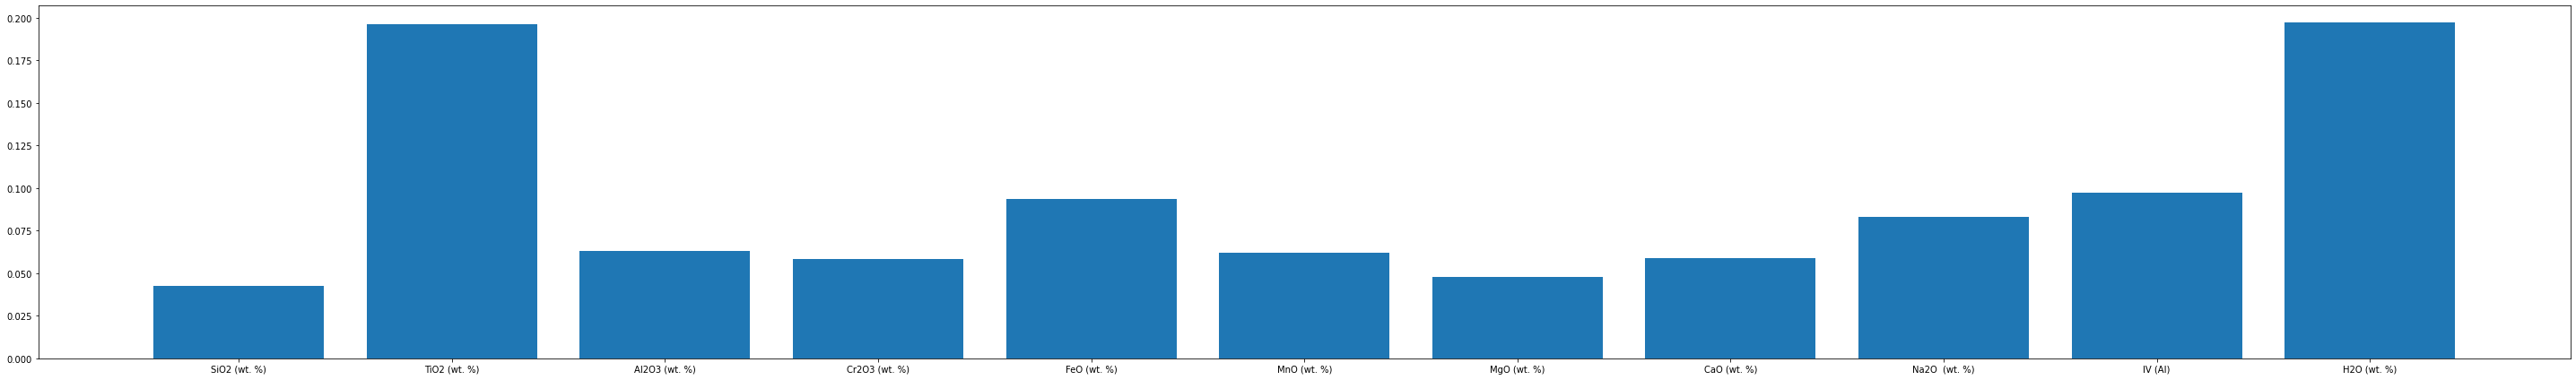

In [281]:
# 柱状图呈现XGBoost预测的特征权重
plt.figure(figsize=(40, 6))
columns_name = data.columns
plt.bar(range(len(columns_name)), best_clf().feature_importances_, tick_label=columns_name)
save_fig("xgb_feature_importance")

Saving figure xgb_feature_importance_fscore


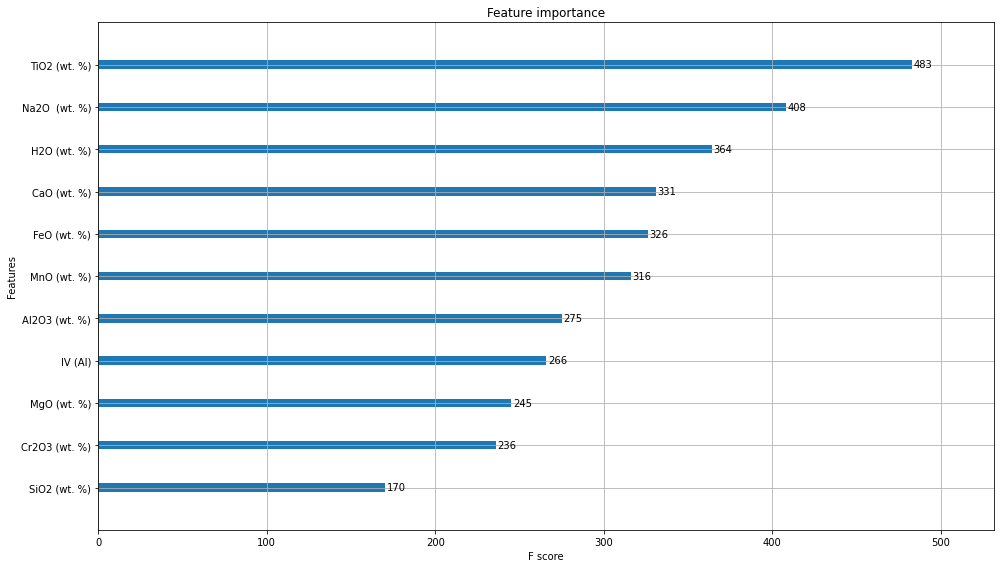

In [282]:
# 根据重要性排序的特征重要图
plt.rcParams["figure.figsize"] = (14, 8)
xgboost.plot_importance(best_clf())
save_fig("xgb_feature_importance_fscore")